In [467]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [468]:
class TicTacToeEnv:
  state = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  turn = 1
  def __init__(self):
    pass

  def reset(self):
    self.state = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    self.turn = np.random.choice([-1, 1])
    return self.state

  def str_state(self, state: list[int]) -> str:
    out = ""
    for s in state:
      if s == 1:
        out += "o"
      elif s == 0:
        out += "-"
      else:
        out += "x"

    return out

  def step(self, action: int) -> tuple[list[int], int, bool, int, dict]:
    """do 1 step in the environment

    Args:
        action (int): action that the agent takes

    Returns:
        tuple[list[int], int, bool, dict]: next state, reward, done, info
    """
    if self.state[action] != 0:
      return self.state, -10, False, {
        "error": True
      }

    self.state[action] = self.turn

    winner = self.check_winner()
    if winner != 0:
      return self.state, winner, True, {
        "winner": winner,
        "error": False
      }

    if self.check_draw():
      return self.state, 0.1, True, {
        "winner": 0,
        "error": False
      }

    self.turn = -self.turn
    return self.state, 0, False, {
      "error": False
    }

  def check_winner(self) -> int:
    for i in range(3):
      # check rows
      if self.state[i*3] == self.state[i*3+1] == self.state[i*3+2] != 0:
        return self.state[i*3]
      # check columns
      if self.state[i] == self.state[i+3] == self.state[i+6] != 0:
        return self.state[i]
    # check diagonals
    if self.state[0] == self.state[4] == self.state[8] != 0:
      return self.state[0]
    if self.state[2] == self.state[4] == self.state[6] != 0:
      return self.state[2]

    return 0

  def check_draw(self) -> bool:
    return 0 not in self.state

  def render(self):
    line1 = self.str_state(self.state)[:3]
    line2 = self.str_state(self.state)[3:6]
    line3 = self.str_state(self.state)[6:]
    print(f"{line1}\n{line2}\n{line3}")

In [469]:
class TicTacToeAgent:
  q_table = json.load(open("out/q_table.json", "r"))
  epsilon = 0.0
  alpha = 0.0
  gamma = 0.0
  action = 0
  state = "---------"

  def __init__(self, epsilon, alpha, gamma):
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma

  def act(self, state: str) -> int:
    self.state = state
    if state not in self.q_table:
      self.q_table[state] = np.zeros(9, dtype=np.float64)
    if np.random.random() < self.epsilon:
      self.action = np.random.choice(9)
      return self.action
    else:
      action = self.q_table[state].argmax()
      # argmaxが複数ある場合はランダムで選ぶ
      if (self.q_table[state] == self.q_table[state].max()).sum() > 1:
        action = np.random.choice(np.where(self.q_table[state] == self.q_table[state].max())[0])
      self.action = action
      return self.action

  def update(self, action: int, reward: int, next_state: str):
    if next_state not in self.q_table:
      self.q_table[next_state] = np.zeros(9, dtype=np.float64)
    # display(self.q_table[self.state])
    # display(self.q_table[next_state])
    self.q_table[self.state][action] += self.alpha * (reward + self.gamma * self.q_table[next_state].max() - self.q_table[self.state][action])


In [470]:
epsilon = 1.0
alpha = 0.1
gamma = 0.9
episode = 500000

In [466]:
env = TicTacToeEnv()
agent1 = TicTacToeAgent(epsilon, alpha, gamma)
# agent2 = TicTacToeAgent(0.1)
win_per_1000 = 0
win_per_1000_list = []
draw_per_1000 = 0
draw_per_1000_list = []
lose_per_1000 = 0
lose_per_1000_list = []
for i in range(episode):
  env.reset()
  winner = 0
  while True:
    action = 0
    if env.turn == 1:
      state = env.state
      action = agent1.act(env.str_state(state))
      next_state, reward, done, info = env.step(action)
      if info["error"] or done:
        agent1.update(action, reward, env.str_state(next_state))
    else:
      action = np.random.choice(9)
      next_state, reward, done, info = env.step(action)
      if not info["error"]:
        agent1.update(agent1.action, reward, env.str_state(next_state))


    next_str_state = env.str_state(next_state)

    if done:
      # env.render()
      winner = info["winner"]
      # print(reward)
      break

  if winner == 1:
    win_per_1000 += 1
  elif winner == -1:
    lose_per_1000 += 1
  else:
    draw_per_1000 += 1


  if i % 1000 == 0 and i != 0:
    win_per_1000_list.append(win_per_1000)
    lose_per_1000_list.append(lose_per_1000)
    draw_per_1000_list.append(draw_per_1000)

    agent1.epsilon = np.max([agent1.epsilon * 0.95, 0.1])
    if agent1.epsilon < 0.1:
      agent1.epsilon = 0.1
    if i > 490000:
      agent1.epsilon = 0.0
    print(f"episode {i} done. epsilon: {agent1.epsilon} win: {win_per_1000 / 1000} draw: {draw_per_1000 / 1000} lose: {lose_per_1000 / 1000}")
    win_per_1000 = 0
    draw_per_1000 = 0
    lose_per_1000 = 0

  if i % 100000 == 0:
    q_table = agent1.q_table.copy()
    for key in q_table:
      q_table[key] = q_table[key].tolist()
    q_table_file = open(f"out/q_table_{i}.json", "w")
    q_table_file.write(json.dumps(q_table))
    q_table_file.close()
    print(f"q_table_{i}.json saved")


q_table_0.json saved
episode 1000 done. epsilon: 0.95 win: 0.434 draw: 0.125 lose: 0.442
episode 2000 done. epsilon: 0.9025 win: 0.445 draw: 0.136 lose: 0.419
episode 3000 done. epsilon: 0.8573749999999999 win: 0.473 draw: 0.126 lose: 0.401
episode 4000 done. epsilon: 0.8145062499999999 win: 0.489 draw: 0.129 lose: 0.382
episode 5000 done. epsilon: 0.7737809374999999 win: 0.497 draw: 0.122 lose: 0.381
episode 6000 done. epsilon: 0.7350918906249998 win: 0.518 draw: 0.127 lose: 0.355
episode 7000 done. epsilon: 0.6983372960937497 win: 0.575 draw: 0.119 lose: 0.306
episode 8000 done. epsilon: 0.6634204312890623 win: 0.612 draw: 0.115 lose: 0.273
episode 9000 done. epsilon: 0.6302494097246091 win: 0.651 draw: 0.114 lose: 0.235
episode 10000 done. epsilon: 0.5987369392383786 win: 0.651 draw: 0.117 lose: 0.232
episode 11000 done. epsilon: 0.5688000922764596 win: 0.658 draw: 0.125 lose: 0.217
episode 12000 done. epsilon: 0.5403600876626365 win: 0.688 draw: 0.123 lose: 0.189
episode 13000 done

KeyboardInterrupt: 

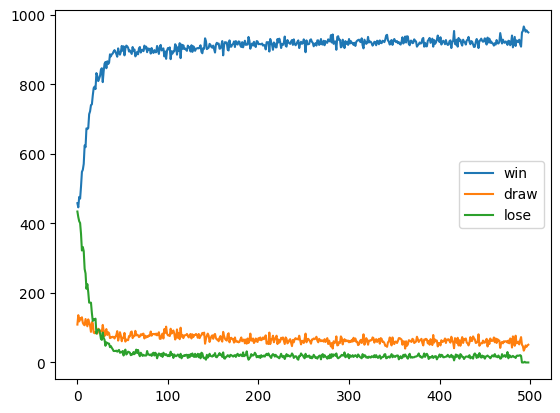

In [ ]:
plt.plot(win_per_1000_list, label="win")
plt.plot(draw_per_1000_list, label="draw")
plt.plot(lose_per_1000_list, label="lose")
plt.legend()

In [ ]:
q_table_file = open("out/q_table.json", "w")
q_table = agent1.q_table.copy()
for key in q_table:
  q_table[key] = q_table[key].tolist()

q_table_file.write(json.dumps(q_table))
q_table_file.close()

In [ ]:
env.reset()
env.render()
while True:
  if env.turn == 1:
    print("AI turn")
    action = agent1.act(env.str_state(env.state))
    env.step(action)
  else:
    print("your turn")
    action_input = input()
    if action_input == "q":
      break
    if action_input == "r":
      env.reset()
      env.render()
      continue
    if not action_input in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]:
      print("invalid input")
      continue
    action = int(action_input)
    env.step(action)
  env.render()
  winner = env.check_winner()
  if winner != 0:
    print(f"winner: {winner}")
    break
  if env.check_draw():
    print("draw")
    break

---
---
---
your turn
---
-x-
---
AI turn
---
-x-
o--
your turn
invalid input
your turn
-x-
-x-
o--
AI turn
-x-
-x-
oo-
your turn
-x-
-x-
oox
AI turn
ox-
-x-
oox
your turn
ox-
xx-
oox
AI turn
ox-
xxo
oox
your turn
oxx
xxo
oox
draw


In [481]:
agent2 = TicTacToeAgent(0.0, 0.0, 0.0)
agent2.q_table = agent1.q_table.copy()
env.reset()
env.render()
agent1_win = 0
agent2_win = 0
draw = 0
logfile = open("out/log.txt", "w")
# agent1 vs agent2
while True:
  if env.turn == 1:
    print("AI1 turn")
    action = agent1.act(env.str_state(env.state))
    _, _, done, info  = env.step(action)
  else:
    print("AI2 turn")
    action = agent2.act(env.str_state(map(lambda x: -x, env.state)))
    _, _, done, info = env.step(action)

  env.render()

  if done:
    winner = env.check_winner()
    env.reset()
    print(winner)
    if winner == 1:
      agent1_win += 1
    elif winner == -1:
      agent2_win += 1
    else:
      draw += 1
    break

display(f"agent1 win: {agent1_win} agent2 win: {agent2_win} draw: {draw}")


---
---
---
AI2 turn
---
-x-
---
AI1 turn
---
-x-
o--
AI2 turn
x--
-x-
o--
AI1 turn
x--
-x-
o-o
AI2 turn
x--
-x-
oxo
AI1 turn
x-o
-x-
oxo
AI2 turn
xxo
-x-
oxo
-1


'agent1 win: 0 agent2 win: 1 draw: 0'